In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.transform as sktr
import torch as to
import torchvision as tovi
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
class Data(Dataset) :
    
    def __init__(self):
        
        super(Data,self).__init__()
        
        self.data = pd.read_csv("../../data/trainMNIST.csv").values
        self.label = pd.read_csv("../../data/trainMNISTlabels.csv").values
        
        self.length = len(self.data)
    
    
    def __getitem__(self, inx) :
        
        inx = np.random.randint(0,self.length)
        
        sample = self.data[inx]
        label = self.label[inx]
        
        img = np.reshape(sample,(1,28,28))
        
        img = to.tensor(img, dtype=to.float32)
        label = to.tensor(label, dtype=to.float32)
        
        return img, label
        
    
    def __len__(self):
        
        return 2000

architecture :

$$1\times28\times28 \xrightarrow{\text{conv:} k_5,s_1}  16 \times 24 \times24 \xrightarrow{\text{maxp:} k_2,s_2} 16\times12\times12 \xrightarrow{\text{conv:}k_3,s_1} 16\times10\times10 \xrightarrow{\text{maxp:}k_2,s_2} 16\times5\times5$$

In [3]:
class Model(nn.Module):
    
    def __init__(self):
        
        super(Model,self).__init__()
            
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)  
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        
        self.linear1 = nn.Linear(400,32)
        self.linear2 = nn.Linear(32,2)
        
        
    def encoder(self,inp):

        
        out = self.conv1(inp)
        out = F.relu(out)
        out, self.inx1 = self.pool(out)

        
        out = self.conv2(out)
        out = F.relu(out)
        out, self.inx2 = self.pool(out)           

        
        out = out.view(-1,400)
        
        out = F.relu(self.linear1(out))  

        out = self.linear2(out)
     
        return out
        
               
    def decoder(self,inp):
    
        self.copy_conv1 = to.tensor(self.conv1.weight, requires_grad=False)
        self.copy_conv2 = to.tensor(self.conv2.weight, requires_grad=False)
        
        self.copy_linear1 = to.tensor(self.linear1.weight, requires_grad=False)
        self.copy_linear2 = to.tensor(self.linear2.weight, requires_grad=False)
      
        out = F.relu(F.linear(inp,self.copy_linear2.t()))
    
        out = F.relu(F.linear(out,self.copy_linear1.t()))

        out = out.view(-1,16,5,5)

        out = F.max_unpool2d(out, self.inx2, kernel_size=2, stride=2)
        out = F.conv_transpose2d(out, self.copy_conv2 )
        out = F.relu(out)

        
        out = F.max_unpool2d(out, self.inx1, kernel_size=2, stride=2)
        out = F.conv_transpose2d(out, self.copy_conv1 )

        
        out = F.tanh(out)

        
        return out
        
        
    
    def forward(self,inp):
        
        out = self.encoder(inp)
        out = self.decoder(out)

        
        return out
    
    


In [4]:
    def evaluate(self,inp):
        
        chk = to.tensor([1],dtype=to.float32)
        
        if type(inp) != type(chk):
            
            # inp = np.transpose(inp, (2,1,0) ) #for images
            inp = to.tensor(inp, dtype=to.float32, device="cuda")
            
        out = forward(inp)
        
        return out

In [5]:
model = Model().cuda()

In [6]:
train_data = Data()
data_loader = DataLoader(train_data,batch_size=32, shuffle=True)

label : tensor([4.])


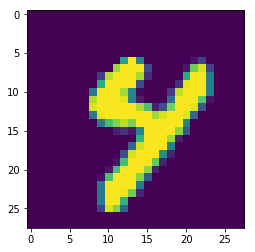

In [7]:
sample, lbl = train_data[1]

print("label :", lbl)

img = sample.detach().cpu().numpy()
plt.imshow(img[0])

In [8]:
epoch = 500
lr = 0.001
Criterion = nn.MSELoss()
Optimizer = to.optim.Adam(model.parameters(), lr=lr)

In [9]:
counter = []
loss_history = [] 
iteration_number= 0

In [10]:
for i in range(epoch):
    
    for data in data_loader :
        
        img, lbl = data
        
        out = model(img.cuda())
        loss = Criterion(out,img.cuda())
        
        
        Optimizer.zero_grad()
        loss.backward()
        Optimizer.step()
        
    print("Epoch number {}\n  Current loss {}\n".format(i,loss.item()))
    counter.append(epoch)
    loss_history.append(loss.item())
        

/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

Epoch number 0
  Current loss 7648.82666015625

Epoch number 1
  Current loss 6635.21533203125

Epoch number 2
  Current loss 8221.759765625

Epoch number 3
  Current loss 6317.60205078125

Epoch number 4
  Current loss 7109.3525390625

Epoch number 5
  Current loss 8139.4619140625

Epoch number 6
  Current loss 6160.9765625

Epoch number 7
  Current loss 7482.29736328125

Epoch number 8
  Current loss 6572.029296875

Epoch number 9
  Current loss 8051.931640625

Epoch number 10
  Current loss 6462.34228515625

Epoch number 11
  Current loss 6915.97216796875

Epoch number 12
  Current loss 7368.46826171875

Epoch number 13
  Current loss 8761.404296875

Epoch number 14
  Current loss 6742.693359375

Epoch number 15
  Current loss 5514.1015625

Epoch number 16
  Current loss 6097.53076171875

Epoch number 17
  Current loss 8129.89453125

Epoch number 18
  Current loss 7857.2744140625

Epoch number 19
  Current loss 5902.38720703125

Epoch number 20
  Current loss 7168.44091796875

Epoch

Epoch number 170
  Current loss 8316.0048828125

Epoch number 171
  Current loss 6819.61669921875

Epoch number 172
  Current loss 7375.0458984375

Epoch number 173
  Current loss 7058.43408203125

Epoch number 174
  Current loss 7814.82958984375

Epoch number 175
  Current loss 6310.7275390625

Epoch number 176
  Current loss 7268.46240234375

Epoch number 177
  Current loss 7624.9609375

Epoch number 178
  Current loss 8233.8388671875

Epoch number 179
  Current loss 7854.23486328125

Epoch number 180
  Current loss 8251.755859375

Epoch number 181
  Current loss 7304.6455078125

Epoch number 182
  Current loss 7346.36279296875

Epoch number 183
  Current loss 7549.4423828125

Epoch number 184
  Current loss 7982.216796875

Epoch number 185
  Current loss 8052.1689453125

Epoch number 186
  Current loss 7607.216796875

Epoch number 187
  Current loss 8630.1787109375

Epoch number 188
  Current loss 7346.7314453125

Epoch number 189
  Current loss 6795.56884765625

Epoch number 190
  

Epoch number 338
  Current loss 6147.03564453125

Epoch number 339
  Current loss 6028.25

Epoch number 340
  Current loss 7989.93505859375

Epoch number 341
  Current loss 6588.5830078125

Epoch number 342
  Current loss 6716.79345703125

Epoch number 343
  Current loss 6980.37451171875

Epoch number 344
  Current loss 6048.50390625

Epoch number 345
  Current loss 6046.1826171875

Epoch number 346
  Current loss 6589.14599609375

Epoch number 347
  Current loss 7355.48828125

Epoch number 348
  Current loss 6518.439453125

Epoch number 349
  Current loss 6067.3369140625

Epoch number 350
  Current loss 7282.75

Epoch number 351
  Current loss 6373.333984375

Epoch number 352
  Current loss 6933.240234375

Epoch number 353
  Current loss 8102.6298828125

Epoch number 354
  Current loss 8290.9091796875

Epoch number 355
  Current loss 7169.47021484375

Epoch number 356
  Current loss 6727.83544921875

Epoch number 357
  Current loss 7291.4169921875

Epoch number 358
  Current loss 8364

In [11]:
len(loss_history)

500

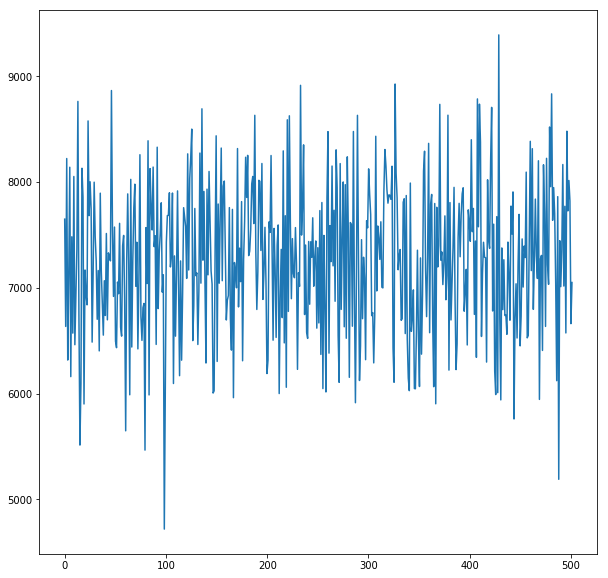

In [12]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,501,num=500),loss_history)

In [13]:
to.save(model.state_dict(),"./autoencoder_linear")

In [14]:
data = Data()
sample_loader = DataLoader(data)
iterator = iter(sample_loader)

label : tensor([[1.]])


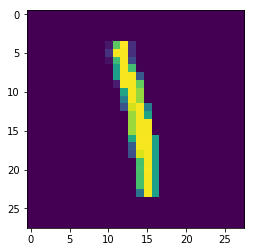

In [15]:
im1, lbl = iterator.next()
img1 = im1.cpu().numpy()

print("label :", lbl)

plt.imshow(img1[0][0])

/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rishi/.conda/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

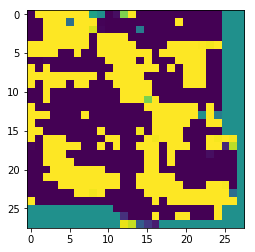

In [16]:
with to.no_grad() :
    out = model(im1.cuda())

img = out.cpu().detach().numpy()
plt.imshow(img[0][0])

In [17]:
plot_data = Data()

In [22]:
plot_loader = DataLoader(plot_data,batch_size=128)

iterator = iter(plot_loader)
data = iterator.next()

points = np.array([[0,0,0]])

for data in plot_loader :   
    img, lb = data
    lb = lb.detach().cpu().numpy()

    with to.no_grad():

        point = model.encoder(img.cuda())
        
        point = point.detach().cpu().numpy()
        point = np.concatenate((point,lb), axis=1)

        points = np.concatenate( (points,point), axis=0 )  

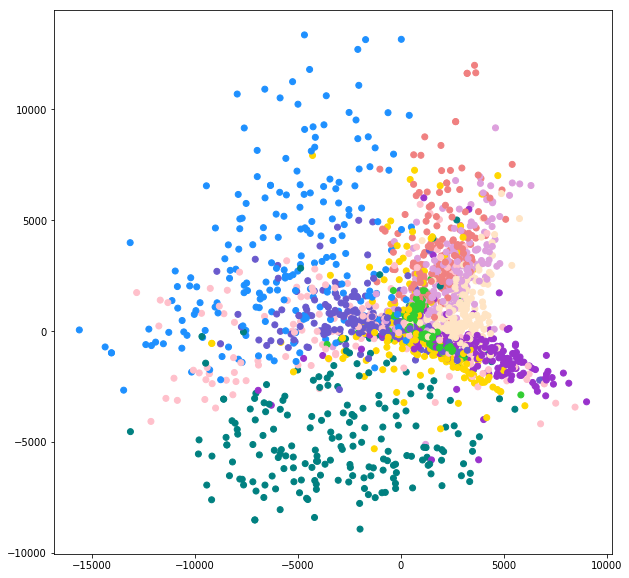

In [23]:
colors = ['teal','limegreen','gold','darkorchid','lightcoral','pink','dodgerblue','bisque','slateblue','plum']
centers = ['darkslategrey','darkgreen','goldenrod','indigo','maroon','crimson','midnightblue','darkorange','darkslateblue','purple']
import matplotlib
plt.figure(figsize=(10,10))
plt.scatter(x=points[:,0],y=points[:,1],c=points[:,2], cmap=matplotlib.colors.ListedColormap(colors))